In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from IPython import display

In [2]:
batch_size_train = 64
batch_size_test = 64

# prepair the dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self, output_size):
        super(Generator, self).__init__()
        
        self.output_size = output_size        
        self.fc1 = nn.Linear(128,512)        
        self.fc2 = nn.Linear(512,64)        
        self.fc3 = nn.Linear(64, output_size * output_size)
        
    
    def forward(self, x):
        
        x = torch.relu(self.fc1(x))        
        x = torch.relu(self.fc2(x))        
        x = torch.tanh(self.fc3(x))  
        x = x.reshape(-1, 1, self.output_size, self.output_size)
        return x
        

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size):        
        super(Discriminator, self).__init__()
        
        self.input_size = input_size
        
        x_in = input_size * input_size
        self.fc1 = nn.Linear(x_in, 512)        
        self.fc2 = nn.Linear(512, self.input_size**2)        
        self.fc3 = nn.Linear(self.input_size**2, 1)
    
    def forward(self, x):
        '''
            receives an images n x n
        '''
        x = x.view(-1, 1, self.input_size**2)
        x = torch.relu(self.fc1(x))        
        x = torch.relu(self.fc2(x))        
        x = torch.tanh(self.fc3(x))
        x = torch.squeeze(x,2)
        
        return x

In [5]:
size_image = 28
img = torch.rand(size_image, size_image)

In [6]:
import matplotlib.pyplot as plt

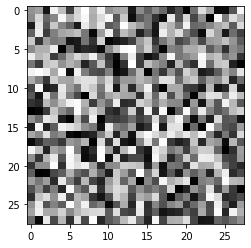

In [7]:
plt.imshow(img.data.numpy(), cmap='gray')

In [8]:
disc = Discriminator(size_image)
gen = Generator(size_image)

In [9]:
noise = torch.rand(128)
gen_image = gen(noise)
print(gen_image.shape)

torch.Size([1, 1, 28, 28])


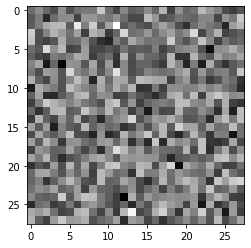

In [10]:
plt.imshow(gen_image.data.numpy().reshape(size_image,size_image), cmap='gray')

In [11]:
pred = disc(gen_image)
print(pred)

tensor([[-0.0024]], grad_fn=<SqueezeBackward1>)


In [12]:
def discriminator_loss(real_output, fake_output):
    # real_loss = F.cross_entropy(torch.ones_like(real_output), real_output)
    # fake_loss = F.cross_entropy(torch.zeros_like(fake_output), fake_output)
    
    real_loss = F.mse_loss(torch.ones_like(real_output), real_output)
    fake_loss = F.mse_loss(torch.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    # loss = F.cross_entropy(torch.ones_like(fake_output, requires_grad=False), fake_output)
    loss = F.mse_loss(torch.ones_like(fake_output), fake_output)
    
    return loss

In [13]:
generator_optimizer = optim.Adam(gen.parameters(), lr=0.01, weight_decay=0.01)
discriminator_optimizer = optim.Adam(disc.parameters(), lr=0.01, weight_decay=0.01)

In [14]:
NUM_EPOCHS = 3000
BATCH_SIZE = 32
noise_dim = 128
num_examples_gen = 32
torch.seed = 129

In [ ]:
for epoch_i in range(NUM_EPOCHS):
    for i, (image_batch, image_targets) in enumerate(train_loader):         

        batch_size = image_batch.shape[0]

        noise = torch.randn(BATCH_SIZE, noise_dim)
        gen_images = gen(noise)

        real_images = disc(image_batch)
        fake_images = disc(gen_images)

        gen_loss = generator_loss(fake_images)
        disc_loss = discriminator_loss(fake_images, real_images)

        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()

        gen_loss.backward(retain_graph=True)
        disc_loss.backward(retain_graph=True)    

        generator_optimizer.step()    
        discriminator_optimizer.step()    

        noise = torch.randn(9, noise_dim)
        genenerated_images = gen(noise)
    
    print("\r {} from {} epochs".format(epoch_i, NUM_EPOCHS), end="", flush=True)

        #display_images(genenerated_images.detach().numpy())            


 237 from 3000 epochs

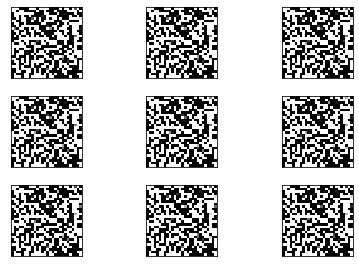

In [22]:
display_images(genenerated_images.detach().numpy())

In [17]:
import time
def display_images(images):
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(images[i][0], cmap='gray', interpolation='none')
        # plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
    fig